# Intro to Deep Learning Challenge 6
This is the response to the Coding challenge https://www.youtube.com/watch?v=cAICT4Al5Ow&t=134s How to make Image Classifier - Intro to Deep Learning #6

## Data
Data can be downloaded at: https://www.kaggle.com/c/dogs-vs-cats/data

## Using Transfer Learning to extract feature vectors of images from Inception Model 

In [1]:
import tensorflow as tf
import numpy as np
import sklearn 
import tensorflow.python.platform
from tensorflow.python.platform import gfile
import os
import re

Inceptoin model was developed by Google for the Image net competition.
To download the imagenet model run the following command 

cd tensorflow/models/image/imagenet python classify_image.py --model_dir Inception/imagenet

Pre trained model will be in the Inception folder                                                                               
Data is added to the inception folder                                                                                       
Folder structure                                                                                                            
  data/                                                                                                                         train/                                                                                                                      
          dogs/                                                                                                                      
              dog.0.jpg                                                                                                            
              ...                                                                                                                  
          cats/                                                                                                                  
              cat.0.jpg                                                                                                            
              ...                                                                                                         
      data/validation/                                                                                                                  
          dogs/                                                                                                                   
              dog.1301.jpg                                                                                                          
              ...                                                                                                                   
          cats/                                                                                                                        
              cat.1301.jpg     
              ...
 
 1024 training images for cats and dogs each.
 416 validation images for cats and dogs each.

In [2]:
#assigning directory addresses of image location
model_dir = "imagenet"
training_images_cats_dir = "data/train/cats/"
training_images_dogs_dir = "data/train/dogs/"

validation_images_cats_dir = "data/validation/cats/"
validation_images_dogs_dir = "data/validation/dogs/"

In [3]:
# storing addresses of all images of cats and dogs for training and validation
training_images_cats = [training_images_cats_dir+f for f in os.listdir(training_images_cats_dir) if re.search('jpg|JPG', f)]
validation_images_cats = [validation_images_cats_dir+f for f in os.listdir(validation_images_cats_dir) if re.search('jpg|JPG', f)]
training_images_dogs = [training_images_dogs_dir+f for f in os.listdir(training_images_dogs_dir) if re.search('jpg|JPG', f)]
validation_images_dogs = [validation_images_dogs_dir+f for f in os.listdir(validation_images_dogs_dir) if re.search('jpg|JPG', f)]

In [4]:
#This function is from classify_image.py which creates graph from saved GraphDef file and returns a saver
def create_graph():
  """Creates a graph from saved GraphDef file and returns a saver."""
  # Creates graph from saved graph_def.pb.
  with tf.gfile.FastGFile(os.path.join(
      model_dir, 'classify_image_graph_def.pb'), 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
    _ = tf.import_graph_def(graph_def, name='')

## Extract feature vectors for images
Now modifying function run_inference_on_image(image) from classify_image.py to extract feature vectors for images
pool_3:0 which is the next to last layer contains 2048 float description of images

In [5]:
def get_bottleneck_values(images):  # modifying name of function
  """Runs inference on an image.

  Args:
    image: Image file name.

  Returns:
    Nothing
  """
  # Creates graph from saved GraphDef.
  create_graph()
  feature_vector_size = 2048 # pool_3:0 contains a float description vector of size 2048  
  with tf.Session() as sess:
    # Some useful tensors:
    # 'softmax:0': A tensor containing the normalized prediction across
    #   1000 labels.
    # 'pool_3:0': A tensor containing the next-to-last layer containing 2048
    #   float description of the image.
    # 'DecodeJpeg/contents:0': A tensor containing a string providing JPEG
    #   encoding of the image.
    # Runs the softmax tensor by feeding the image_data as input to the graph.
    bottleneck_tensor = sess.graph.get_tensor_by_name('pool_3:0') #changing from softmax:0 to pool_3:0
    feature_vectors = np.empty([len(images),2048])
    for i,image in enumerate(images): # Iterating through images 
        image_data = tf.gfile.FastGFile(image, 'rb').read()
        feature_vector = sess.run(bottleneck_tensor,
                           {'DecodeJpeg/contents:0': image_data})
        feature_vector = np.squeeze(feature_vector)
        feature_vectors[i,:] = feature_vector 
        if(i % 10 == 0): #Print out just to see the function is processing 
            print("Processing image %d  %s"%(i,image))
    return feature_vectors

## Creating bottleneck values
Extract features for training and validation images.

In [6]:
# Extracting bottleneck values for training cat images
feature_cats = get_bottleneck_values(training_images_cats)

Processing image 0  data/train/cats/cat.702.jpg
Processing image 10  data/train/cats/cat.193.jpg
Processing image 20  data/train/cats/cat.451.jpg
Processing image 30  data/train/cats/cat.730.jpg
Processing image 40  data/train/cats/cat.883.jpg
Processing image 50  data/train/cats/cat.927.jpg
Processing image 60  data/train/cats/cat.866.jpg
Processing image 70  data/train/cats/cat.114.jpg
Processing image 80  data/train/cats/cat.560.jpg
Processing image 90  data/train/cats/cat.693.jpg
Processing image 100  data/train/cats/cat.453.jpg
Processing image 110  data/train/cats/cat.2.jpg
Processing image 120  data/train/cats/cat.167.jpg
Processing image 130  data/train/cats/cat.293.jpg
Processing image 140  data/train/cats/cat.176.jpg
Processing image 150  data/train/cats/cat.671.jpg
Processing image 160  data/train/cats/cat.654.jpg
Processing image 170  data/train/cats/cat.851.jpg
Processing image 180  data/train/cats/cat.522.jpg
Processing image 190  data/train/cats/cat.848.jpg
Processing im

As generating bottlenecks take time it is better to save them. 

In [7]:
import pickle
pickle.dump(feature_cats, open('feature_cats', 'wb'))

Similarly bottlenecks can be generated for training images of dogs,validation images of dogs and cats

feature_dogs = get_bottleneck_values(training_images_dogs)
pickle.dump(feature_dogs,open('feature_dogs','wb'))

I had generated and stored it.

In [8]:
# Loading stored values of bottleneck values
feature_dogs = pickle.load(open('feature_dogs','rb'))
feature_cats = pickle.load(open('feature_cats','rb'))

In [9]:
# Concatenating feature vectors into one numpy array to be used for training
train_features = np.concatenate((feature_cats,feature_dogs),axis = 0)

In [10]:
#Similarly loading concatenated feature vectors for validation(previously generated)
validation_features = pickle.load(open('val_features','rb'))

In [11]:
#Looking into shape of training features
shape_train = train_features.shape
shape_train

(2048, 2048)

In [12]:
#Generating train labels for the data. Assigning 0 to cat and 1 to dog
#array of 1024 0's and 1024 1's corresponding to train_features which contain 1024 cat vectors followed by 1024 dog vectors
train_labels = np.array([0]*(shape_train[0]//2) + [1]*(shape_train[0]//2))

In [13]:
shape_val = validation_features.shape
shape_val

(832, 2048)

In [14]:
#Generating validation labels for the data. Assigning 0 to cat and 1 to dog
#array of 416 0's and 416 1's corresponding to validation_features which contain 416 cat vectors followed by 416 dog vectors
val_labels = np.array([0]*(shape_val[0]//2) + [1]*(shape_val[0]//2))
val_labels.shape

(832,)

## Building fully connected neural network using Keras

In [15]:
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras import optimizers

Using TensorFlow backend.


In [16]:
nn = Sequential()
nn.add(Dense(256,input_dim=shape_train[0],activation = 'relu'))
nn.add(Dropout(0.5))
nn.add(Dense(1, activation='sigmoid'))
nn.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

## Training the neural network

In [17]:
nb_epoch=30
nn.fit(train_features, train_labels,
          nb_epoch=nb_epoch, batch_size=32,
          validation_data=(validation_features, val_labels))

Train on 2048 samples, validate on 832 samples
Epoch 1/30
2048/2048 [==============================] - 1s - loss: 0.1768 - acc: 0.9419 - val_loss: 0.0177 - val_acc: 0.9964

In [18]:
#Saving weights of model
nn.save_weights('bottleneck_train.h5')

## Evaluating the model

In [20]:
nn.evaluate(validation_features, val_labels)

448/832 [===============>..............] - ETA: 0s

[0.00083969013266154823, 1.0]

## Predicting for few Validation Images

In [21]:
from IPython.display import Image

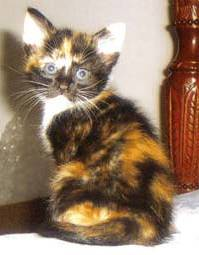

In [22]:
#First validation image of cat
Image(validation_images_cats[0])

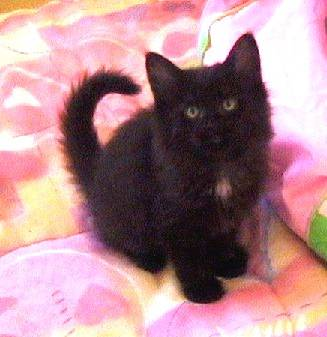

In [23]:
Image(validation_images_cats[1])

In [24]:
#Taking first two validation images of cats
test_input = validation_features[0:2]
nn.predict(test_input)

array([[  7.77718784e-27],
       [  4.77545885e-11]], dtype=float32)

Output is nerly 0 which corresponds to cat

## Predicting outputs for random images containing dogs and cats

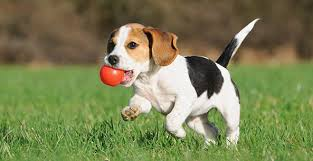

In [25]:
# Testing for a random image taken from web
Image('download.jpg')

In [28]:
# Generating bottlenecks for random image
random_sample = ['download.jpg']
feature = get_bottleneck_values(random_sample[0:1])

Processing image 0  download.jpg


In [29]:
#Predict the output
nn.predict(feature)

array([[ 1.]], dtype=float32)

Output is 1 which corresponds to dog

In [30]:
# Testing for a random image which is cat
random_sample = ['cat_download.jpg']
feature = get_bottleneck_values(random_sample[0:1])

Processing image 0  cat_download.jpg


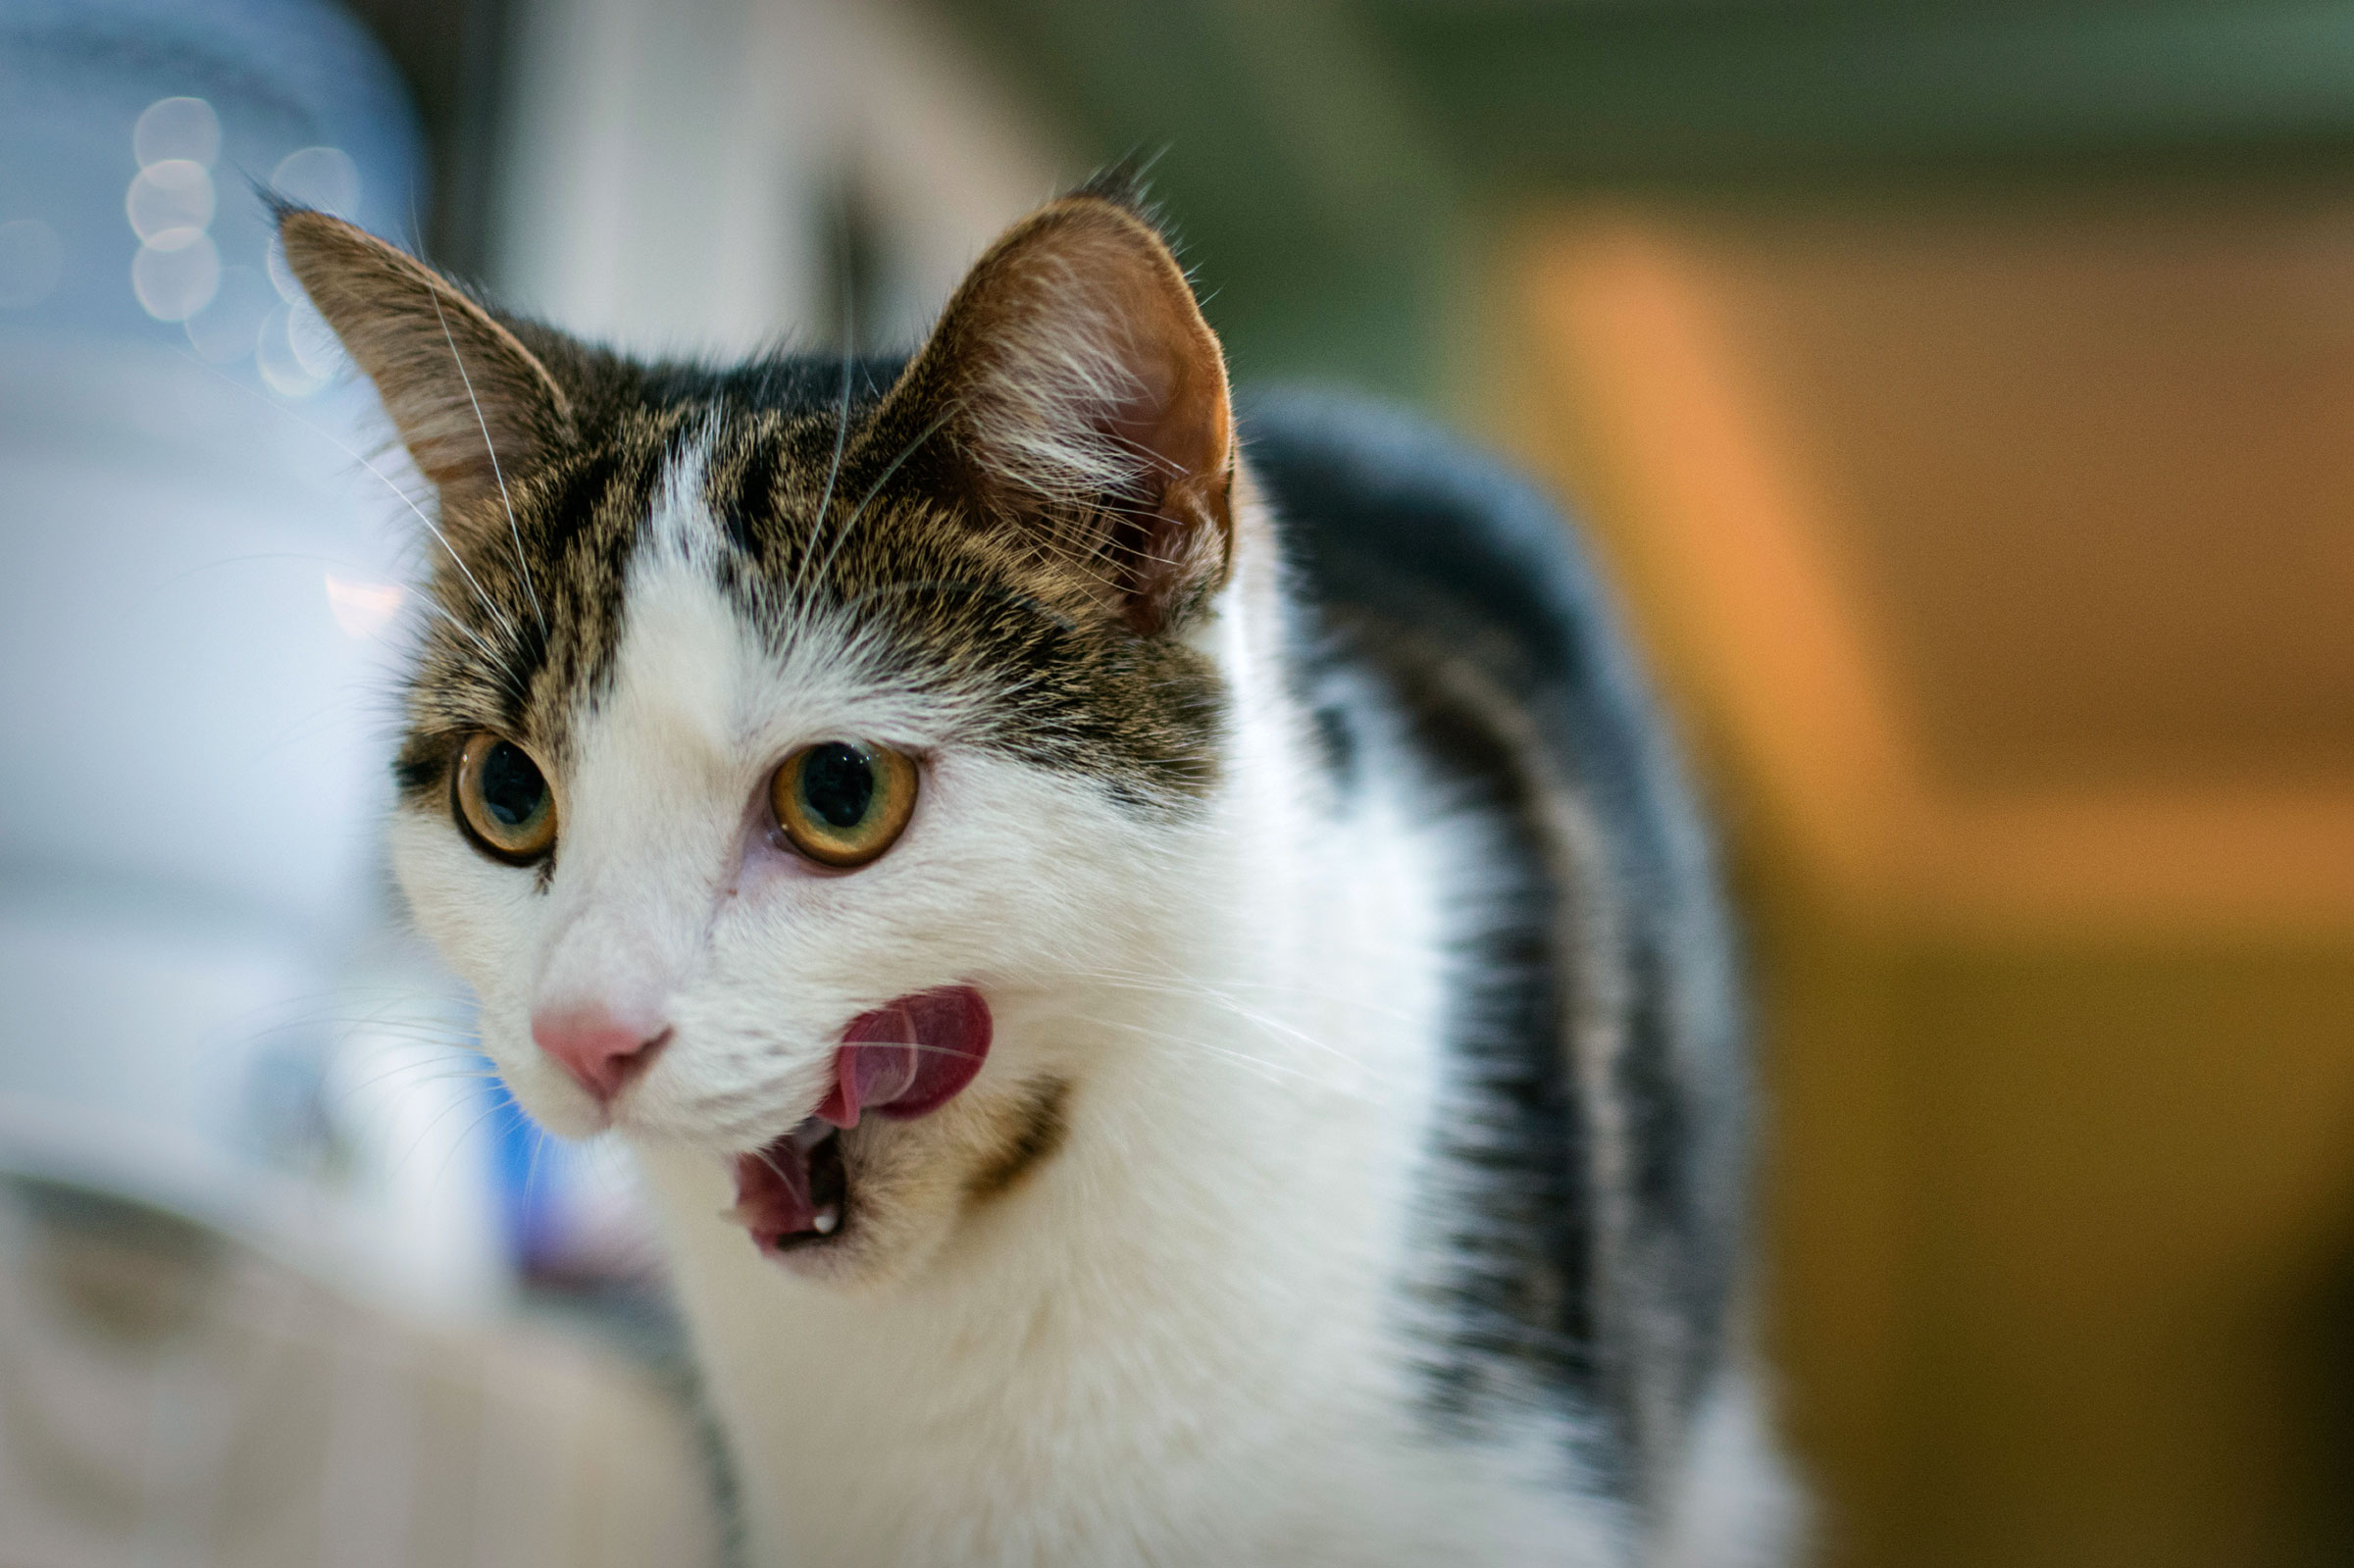

In [32]:
Image('cat_download.jpg')

In [33]:
#Predict the output
nn.predict(feature)

array([[  6.33879085e-21]], dtype=float32)

Output is close to 0 which corresponds to cat